# **Analysis of bias-adjusted climatic varible on North Italy**

#### The following Notebook analysis different climate variable produced by different combination of GCM and RCM and bias adjusted with quantile mapping 

## Libraries Import

In [51]:
import xarray as xr
import dask
import matplotlib.pyplot as plt
import glob
import ipywidgets as widgets
from IPython.display import display
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# Folder where file are stored 
data_path = r"C:\Users\Veronica\OneDrive - Politecnico di Milano\POLIMI\SAHARA\prova"

## Temperature

In [3]:
# Data load
rcp26_files = sorted(glob.glob(f"{data_path}\*tas*rcp26*.nc"))
rcp45_files = sorted(glob.glob(f"{data_path}\*tas*rcp45*.nc"))
rcp85_files = sorted(glob.glob(f"{data_path}\*tas*rcp85*.nc"))

obs = sorted(glob.glob(f"{data_path}\*E-OBS*mean_temp*.nc"))

In [6]:
ds_rcp26 = xr.open_mfdataset(
    rcp26_files,
    combine='by_coords',
    #chunks={"time": 1825}   # Esempio: 1 anno per chunk
)

ds_rcp45 = xr.open_mfdataset(
    rcp45_files,
    combine='by_coords',
    #chunks={"time": 1825}
)

ds_rcp85 = xr.open_mfdataset(
    rcp85_files,
    combine='by_coords',
    #chunks={"time": 1825}
)

ds_obs = xr.open_mfdataset(
    obs,
    combine='by_coords',
    #chunks={"time": 1825}
)

In [8]:
# Mean on spatial domain (lat e lon)
tas_spatial_mean_26 = ds_rcp26["tas"].mean(dim=["y","x"])
tas_spatial_mean_45 = ds_rcp45["tas"].mean(dim=["y","x"])
tas_spatial_mean_85 = ds_rcp85["tas"].mean(dim=["y","x"])
tas_spatial_mean_obs = ds_obs["tg"].mean(dim=["Easting","Northing"])

# Annual Mean
tas_annual_mean_26 = tas_spatial_mean_26.resample(time="1Y").mean() -273.15
tas_annual_mean_45 = tas_spatial_mean_45.resample(time="1Y").mean() -273.15
tas_annual_mean_85 = tas_spatial_mean_85.resample(time="1Y").mean() -273.15
tas_annual_mean_obs = tas_spatial_mean_obs.resample(time="1Y").mean() 

C:\Users\Veronica\anaconda3\envs\climate-env\lib\site-packages\xarray\groupers.py:490: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
C:\Users\Veronica\anaconda3\envs\climate-env\lib\site-packages\xarray\groupers.py:490: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
C:\Users\Veronica\anaconda3\envs\climate-env\lib\site-packages\xarray\groupers.py:490: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
C:\Users\Veronica\anaconda3\envs\climate-env\lib\site-packages\xarray\groupers.py:490: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


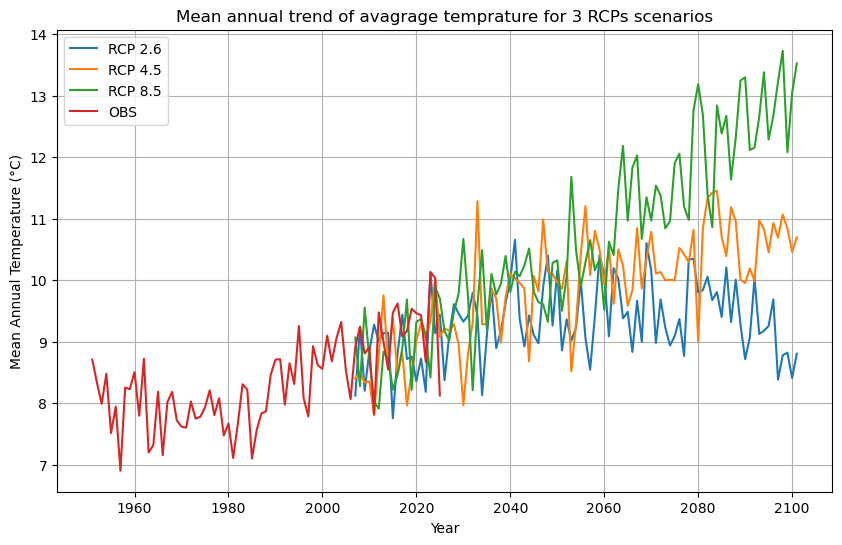

In [10]:
# Visualization of general trend
plt.figure(figsize=(10, 6))

plt.plot(tas_annual_mean_26.time, tas_annual_mean_26, label="RCP 2.6")
plt.plot(tas_annual_mean_45.time, tas_annual_mean_45, label="RCP 4.5")
plt.plot(tas_annual_mean_85.time, tas_annual_mean_85, label="RCP 8.5")
plt.plot(tas_annual_mean_obs.time, tas_annual_mean_obs, label="OBS")

plt.xlabel("Year")
plt.ylabel("Mean Annual Temperature (°C)")
plt.title("Mean annual trend of avagrage temprature for 3 RCPs scenarios")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
obs_renamed = ds_obs.rename({'Easting': 'x', 'Northing': 'y'})
obs_interp = obs_renamed.interp_like(ds_rcp26)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 10),
                         sharex=True, sharey=True, constrained_layout=True)

# Metti in una lista gli scenari con i rispettivi dataset
rcps = [
    ("RCP2.6", ds_rcp26),
    ("RCP4.5", ds_rcp45),
    ("RCP8.5", ds_rcp85)
]

# Metti in una lista i periodi temporali
periods = [
    ("2010-2039", "2010", "2039"),
    ("2040-2069", "2040", "2069"),
    ("2070-2100", "2070", "2099")
]
# Calcola la media osservata nello stesso periodo
obs_period_mean = obs_renamed['tg'].sel(time=slice("1980", "2023")).mean(dim='time')
obs_period_mean = obs_period_mean 

for i, (period_label, start, end) in enumerate(periods):
    for j, (rcp_label, ds_rcp) in enumerate(rcps):
        ax = axes[i, j]
        
        # 1. Calcola la media nel periodo (RCP)
        rcp_period_mean = ds_rcp['tas'].sel(time=slice(start, end)).mean(dim='time')
        rcp_period_mean = rcp_period_mean - 273.15

        # 3. Differenza RCP - OBS (°C)
        diff_map = rcp_period_mean - obs_period_mean
        
        # 4. Plot della differenza come mappa
        # Se diff_map ha dimensioni (y, x), usiamo .plot() di xarray
        im = diff_map.plot(ax=ax, 
                           cmap='hot_r', 
                           add_colorbar=False)  # Niente colorbar singola per subplot
        
        # Titolo del subplot
        ax.set_title(f"{rcp_label}\n{period_label}", fontsize=10)

# Aggiungiamo una colorbar comune all'intera figura
cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.08)
cbar.set_label("Δ T (°C)", fontsize=12)

#plt.tight_layout()
plt.show()

In [ ]:
# Imposta periodo e scenari
start_year = 2010
end_year = 2100

scenarios = {
    "RCP2.6": ds_rcp26,
    "RCP4.5": ds_rcp45,
    "RCP8.5": ds_rcp85
}

# Usa il nuovo modo per ottenere la colormap 'viridis'
cmap = plt.colormaps.get_cmap("viridis")

# Calcola il numero di blocchi di 7 anni
n_blocks = int(np.ceil((end_year - start_year + 1) / 7.0))
norm = plt.Normalize(vmin=start_year, vmax=start_year + n_blocks * 7 - 1)

# Prepara la figura con 3 subplot (uno per scenario)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,6), sharey=True, constrained_layout=True)

for ax, (label, ds) in zip(axes, scenarios.items()):
    # Seleziona il periodo, media spaziale e conversione in °C
    ts = ds['tas'].sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31")).mean(dim=['x','y']) - 273.15
    # Moving average su 15 giorni
    ts_smooth = ts.rolling(time=15, center=True).mean()
    
    # Crea la coordinata 'block' come array NumPy (blocchi di 7 anni)
    block = ((ts_smooth.time.dt.year.values - start_year) // 7)
    ts_smooth = ts_smooth.assign_coords(block=("time", block))
    
    # Raggruppa per blocco di 7 anni
    groups = ts_smooth.groupby("block")
    
    for b, da in groups:
        # Rimuovi eventuali leap day
        da = da.where(da.time.dt.dayofyear != 366, drop=True)
        # Raggruppa per giorno dell'anno e calcola la media (ciclo stagionale)
        daily_cycle = da.groupby("time.dayofyear").mean(dim="time")
        
        # Estrai il giorno dell'anno e i valori
        doy = daily_cycle.coords["dayofyear"].values
        temp_values = daily_cycle.values
        
        # Calcola l'anno centrale del blocco (approssimato)
        central_year = start_year + b * 7 + 3
        color = cmap(norm(central_year))
        
        ax.plot(doy, temp_values, linewidth=2, color=color, 
                label=f"{int(start_year + b * 7)}-{min(int(start_year + b * 7 + 6), end_year)}")
    
    ax.set_title(label, fontsize=12)
    ax.set_xlabel("Day of year")
    ax.grid(True)
    #ax.legend(fontsize=8)

axes[0].set_ylabel("Average Temperature (°C)")

# Crea una colorbar comune per interpretare i colori
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # necessario per la colorbar
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.08)
cbar.set_label("Year", fontsize=12)

plt.show()

In [ ]:
del tas_annual_mean_26, tas_annual_mean_45, tas_annual_mean_85, obs_annual_mean_85
del ds_rcp26, ds_rcp45, ds_rcp85, ds_obs

## T max

In [4]:
# Data load
rcp26_files = sorted(glob.glob(f"{data_path}\*tasmax*rcp26*.nc"))
rcp45_files = sorted(glob.glob(f"{data_path}\*tasmax*rcp45*.nc"))
rcp85_files = sorted(glob.glob(f"{data_path}\*tasmax*rcp85*.nc"))

obs = sorted(glob.glob(f"{data_path}\*E-OBS*max_temp*.nc"))

In [7]:
ds_rcp26 = xr.open_mfdataset(
    rcp26_files,
    combine='by_coords',
    #chunks={"time": 1825}   # Esempio: 1 anno per chunk
).load()

ds_rcp45 = xr.open_mfdataset(
    rcp45_files,
    combine='by_coords',
    #chunks={"time": 1825}
).load()

ds_rcp85 = xr.open_mfdataset(
    rcp85_files,
    combine='by_coords',
    #chunks={"time": 1825}
).load()

ds_obs = xr.open_mfdataset(
    obs,
    combine='by_coords',
    #chunks={"time": 1825}
).load()

In [ ]:
# Mean on spatial domain (lat e lon)
tas_spatial_mean_26 = ds_rcp26["tasmax"].mean(dim=["y","x"])
tas_spatial_mean_45 = ds_rcp45["tasmax"].mean(dim=["y","x"])
tas_spatial_mean_85 = ds_rcp85["tasmax"].mean(dim=["y","x"])
tas_spatial_mean_obs = ds_obs["tx"].mean(dim=["Easting","Northing"])

# Annual Mean
tas_annual_mean_26 = tas_spatial_mean_26.resample(time="1Y").mean() -273.15
tas_annual_mean_45 = tas_spatial_mean_45.resample(time="1Y").mean() -273.15
tas_annual_mean_85 = tas_spatial_mean_85.resample(time="1Y").mean() -273.15
tas_annual_mean_obs = tas_spatial_mean_obs.resample(time="1Y").mean() 

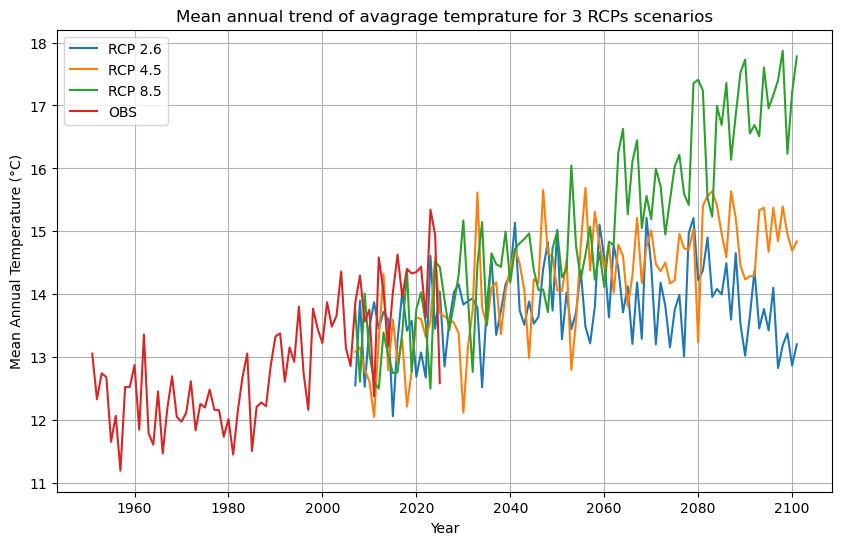

In [15]:
# Visualization of general trend
plt.figure(figsize=(10, 6))

plt.plot(tas_annual_mean_26.time, tas_annual_mean_26, label="RCP 2.6")
plt.plot(tas_annual_mean_45.time, tas_annual_mean_45, label="RCP 4.5")
plt.plot(tas_annual_mean_85.time, tas_annual_mean_85, label="RCP 8.5")
plt.plot(tas_annual_mean_obs.time, tas_annual_mean_obs, label="OBS")

plt.xlabel("Year")
plt.ylabel("Mean Annual Temperature (°C)")
plt.title("Mean annual trend of avagrage temprature for 3 RCPs scenarios")
plt.legend()
plt.grid(True)
plt.show()

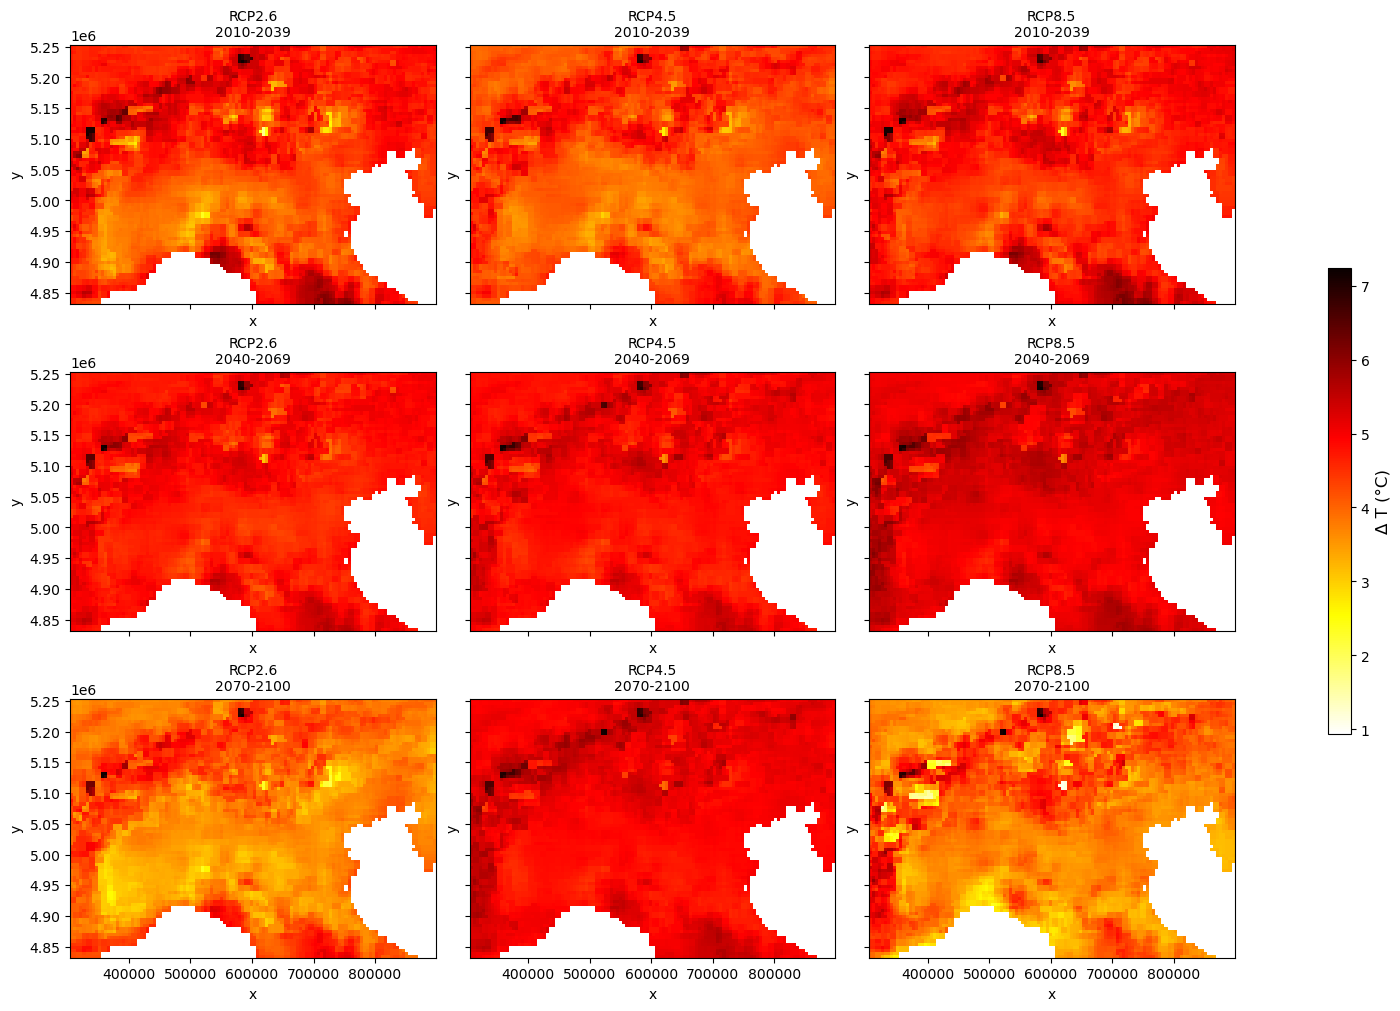

In [27]:
obs_renamed = ds_obs.rename({'Easting': 'x', 'Northing': 'y'})
#obs_interp = obs_renamed.interp_like(ds_rcp26)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 10),
                         sharex=True, sharey=True, constrained_layout=True)

# Metti in una lista gli scenari con i rispettivi dataset
rcps = [
    ("RCP2.6", ds_rcp26),
    ("RCP4.5", ds_rcp45),
    ("RCP8.5", ds_rcp85)
]

# Metti in una lista i periodi temporali
periods = [
    ("2010-2039", "2010", "2039"),
    ("2040-2069", "2040", "2069"),
    ("2070-2100", "2095", "2100")
]
# Calcola la media osservata nello stesso periodo
obs_period_mean = obs_renamed['tx'].sel(time=slice("1980", "2023")).mean(dim='time')
obs_period_mean = obs_period_mean 

for i, (period_label, start, end) in enumerate(periods):
    for j, (rcp_label, ds_rcp) in enumerate(rcps):
        ax = axes[i, j]
        
        # 1. Calcola la media nel periodo (RCP)
        rcp_period_mean = ds_rcp['tasmax'].sel(time=slice(start, end)).mean(dim='time')
        rcp_period_mean = rcp_period_mean - 273.15

        # 3. Differenza RCP - OBS (°C)
        diff_map = rcp_period_mean - obs_period_mean
        
        # 4. Plot della differenza come mappa
        # Se diff_map ha dimensioni (y, x), usiamo .plot() di xarray
        im = diff_map.plot(ax=ax, 
                           cmap='hot_r', 
                           add_colorbar=False)  # Niente colorbar singola per subplot
        
        # Titolo del subplot
        ax.set_title(f"{rcp_label}\n{period_label}", fontsize=10)

# Aggiungiamo una colorbar comune all'intera figura
cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.08)
cbar.set_label("Δ T (°C)", fontsize=12)

#plt.title("Relative variation from historical values")
#plt.tight_layout()
plt.show()

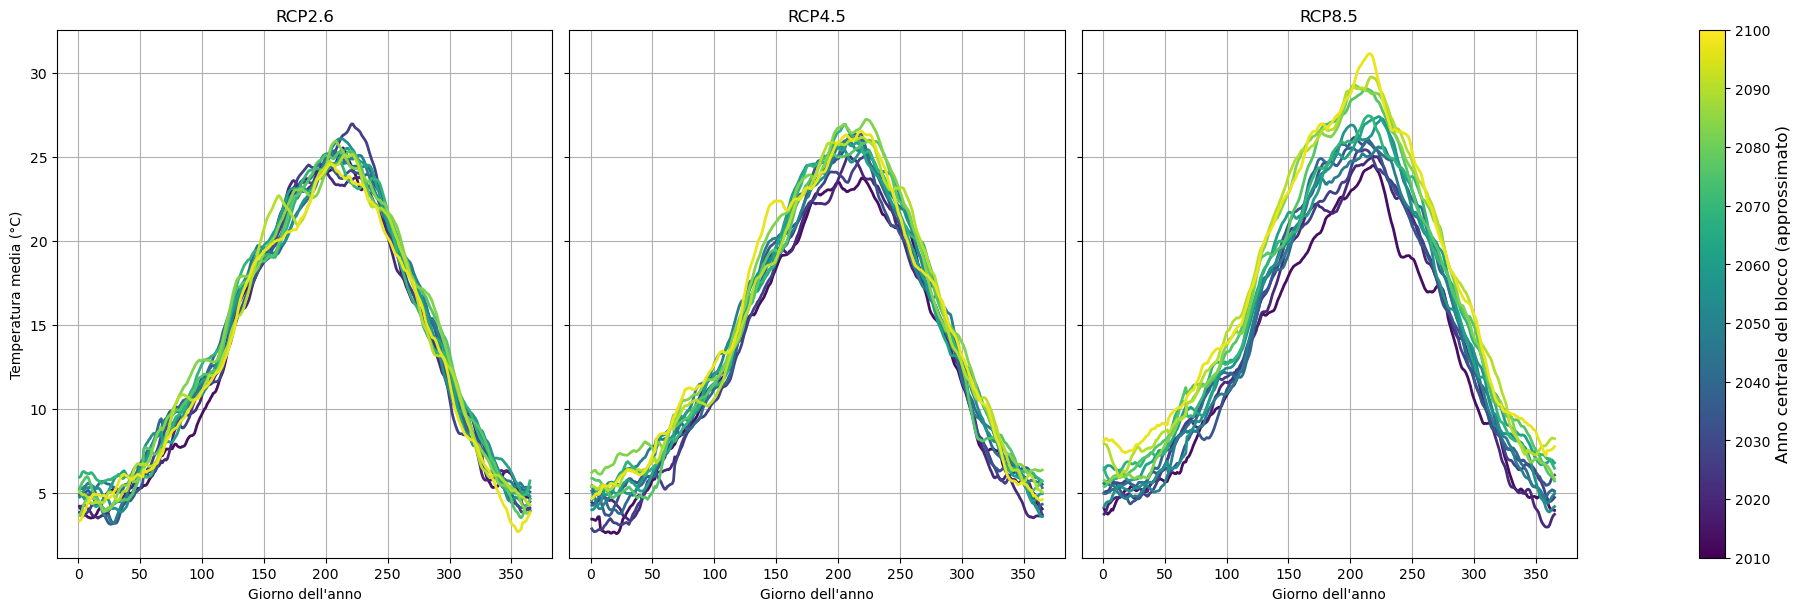

In [61]:
# Imposta periodo e scenari
start_year = 2010
end_year = 2100

scenarios = {
    "RCP2.6": ds_rcp26,
    "RCP4.5": ds_rcp45,
    "RCP8.5": ds_rcp85
}

# Usa il nuovo modo per ottenere la colormap 'viridis'
cmap = plt.colormaps.get_cmap("viridis")

# Calcola il numero di blocchi di 7 anni
n_blocks = int(np.ceil((end_year - start_year + 1) / 7.0))
norm = plt.Normalize(vmin=start_year, vmax=start_year + n_blocks * 7 - 1)

# Prepara la figura con 3 subplot (uno per scenario)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,6), sharey=True, constrained_layout=True)

for ax, (label, ds) in zip(axes, scenarios.items()):
    # Seleziona il periodo, media spaziale e conversione in °C
    ts = ds['tasmax'].sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31")).mean(dim=['x','y']) - 273.15
    # Moving average su 15 giorni
    ts_smooth = ts.rolling(time=15, center=True).mean()
    
    # Crea la coordinata 'block' come array NumPy (blocchi di 7 anni)
    block = ((ts_smooth.time.dt.year.values - start_year) // 7)
    ts_smooth = ts_smooth.assign_coords(block=("time", block))
    
    # Raggruppa per blocco di 7 anni
    groups = ts_smooth.groupby("block")
    
    for b, da in groups:
        # Rimuovi eventuali leap day
        da = da.where(da.time.dt.dayofyear != 366, drop=True)
        # Raggruppa per giorno dell'anno e calcola la media (ciclo stagionale)
        daily_cycle = da.groupby("time.dayofyear").mean(dim="time")
        
        # Estrai il giorno dell'anno e i valori
        doy = daily_cycle.coords["dayofyear"].values
        temp_values = daily_cycle.values
        
        # Calcola l'anno centrale del blocco (approssimato)
        central_year = start_year + b * 7 + 3
        color = cmap(norm(central_year))
        
        ax.plot(doy, temp_values, linewidth=2, color=color, 
                label=f"{int(start_year + b * 7)}-{min(int(start_year + b * 7 + 6), end_year)}")
    
    ax.set_title(label, fontsize=12)
    ax.set_xlabel("Day of year")
    ax.grid(True)
    #ax.legend(fontsize=8)

axes[0].set_ylabel("Max Temperature (°C)")

# Crea una colorbar comune per interpretare i colori
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # necessario per la colorbar
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.08)
cbar.set_label("Year", fontsize=12)

plt.show()

In [ ]:
del tas_annual_mean_26, tas_annual_mean_45, tas_annual_mean_85, obs_annual_mean_85
del ds_rcp26, ds_rcp45, ds_rcp85, ds_obs